#Instaling our neccesary libraries and cloning our needed github reposotories ⚓
---



In [1]:
%%capture
# !git clone https://github.com/ultralytics/ultralytics
!pip install ultralytics

In [2]:
import numpy as np
import pandas as pd
from pathlib import Path
from shutil import copyfile
import os
import zipfile
from collections import defaultdict
import matplotlib.pyplot as plt
import yaml
from IPython.display import Image, clear_output
import plotly.express as px
from ultralytics import YOLO
from PIL import Image
import cv2

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


## Now we are conecting our notebook with our own google drive.


In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).




---



---


## 🖖 Our first task is to enter to this website [roboflow](https://universe.roboflow.com/work-safe-project/safety-vest---v4) sign in using your google account and download the dataset in a yolov8 format to our local desktop memory and without unziping the file, we should upload the zip file to our colab notebook. ⛳


---



**Here we first write a costum function to extract our dataset which we got it from roboflow**

what this function will do?
- Extract a zip file to a specified destination directory

**our two params**

*zip_file_path:*
- Path to the zip file you want to extract

*destination_dir:*

- Destination directory where you want to extract the files


In [6]:
# You dont need to modify this cell, only run it because its a function which we will use it later.

def extract_zip(zip_file_path, destination_dir):
    """
    Extract a zip file to a specified destination directory.

    :param zip_file_path: Path to the zip file you want to extract.
    :param destination_dir: Destination directory where you want to extract the files.
    """
    # Create the destination directory if it doesn't exist
    os.makedirs(destination_dir, exist_ok=True)

    # Unzip the file
    with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
        zip_ref.extractall(destination_dir)

    # List the contents of the extracted directory
    extracted_files = os.listdir(destination_dir)
    print("Extracted files:", extracted_files)




**Here we are using our custom function to unzip our [dataset](https://universe.roboflow.com/work-safe-project/safety-vest---v4)**

which means we need to change **2 things** in our next cell:
- copy the path for our dataset and past it in the **zip_file_path** variable .
- since the previous function was disigned to create a directory with the name **Dataset**  where we will store our zip dataset content, we dont need to create distination folder we only need to keep destination_directory variable as it is .


In [7]:
zip_file_path = '/content/drive/MyDrive/Safety vest - v4.v3i.yolov8.zip'
destination_directory = '/content/Dataset'

extract_zip(zip_file_path, destination_directory)


Extracted files: ['README.dataset.txt', 'test', 'valid', 'data.yaml', 'train', 'README.roboflow.txt']


#Being one with the data

---
📊 **In order to understand how your data is distributed we need to visualize it so we check which class is presented more and which one is less**  ⚖
---
now its time to write another function so we can plot a graph which can show us the classes accurence in our dataset using the data classes indexes.
all what we should do is run the cell so we can use it later, no need to change anything. 🤪

In [8]:
# ploting the classes accurence in the data using the classes indexes

def count_class_occurrences_txt(annotation_dirs, classes):
    class_counts = defaultdict(int)

    # Iterate through the annotation directories
    for annotation_dir in annotation_dirs:
        # Iterate through the text annotation files in the specified directory
        for filename in os.listdir(annotation_dir):
            if filename.endswith('.txt'):
                txt_path = os.path.join(annotation_dir, filename)

                # Read the lines from the text file
                with open(txt_path, 'r') as file:
                    lines = file.readlines()

                # Extract class IDs from each line and map them to class names
                for line in lines:
                    parts = line.strip().split()
                    if parts:  # Ensure the line is not empty
                        class_id = int(parts[0])
                        if 0 <= class_id < len(classes):
                            class_name = classes[class_id]
                            class_counts[class_name] += 1

    return dict(class_counts)


#Data Visualisation 🦾
Now its time to use our previous function.

all what we need to dom is to replace the **class_list** variable with your own class list.

where i will find my own class_list ? 🤔

- Look at your left corner and find a folder with the name **Dataset** click on it
- Now look at a file with the name **data.yaml** open it
- Look for python list, copy it and use it in the your next code 🙃


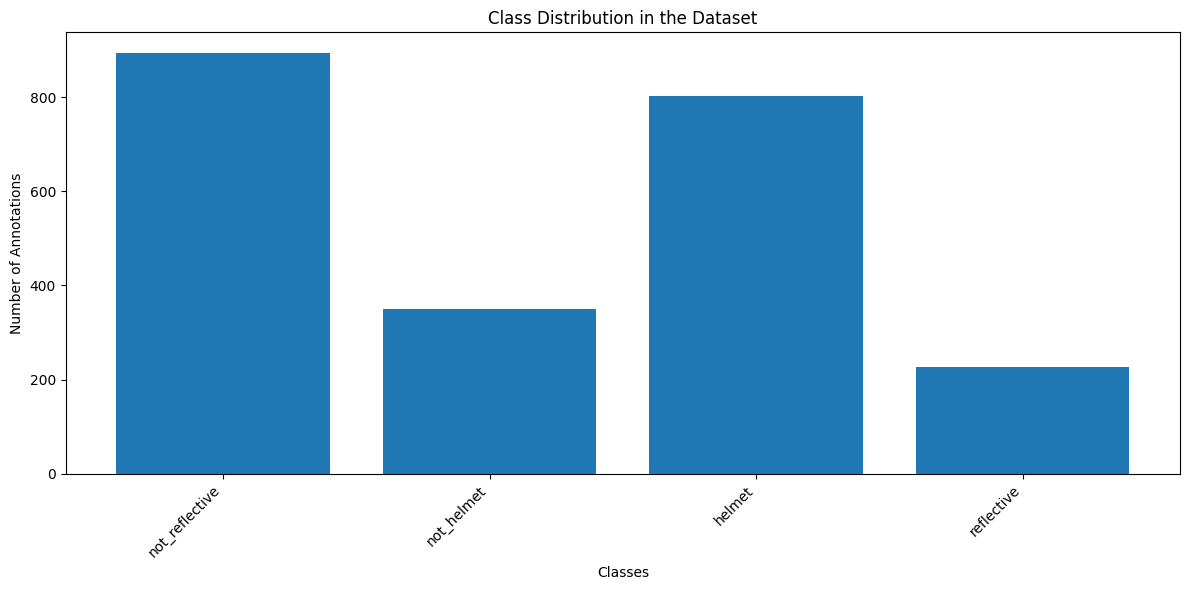

In [9]:
#keep this variable as it is no need to change the paths .
annotation_directories =  ['/content/Dataset/train/labels', '/content/Dataset/valid/labels', '/content/Dataset/test/labels']

#here you should use your own classes
class_list = ['helmet', 'not_helmet', 'not_reflective', 'reflective']

class_occurrences = count_class_occurrences_txt(annotation_directories, class_list)

# Create a bar plot to visualize class occurrences
plt.figure(figsize=(12, 6))
plt.bar(class_occurrences.keys(), class_occurrences.values())
plt.xlabel('Classes')
plt.ylabel('Number of Annotations')
plt.title('Class Distribution in the Dataset')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [ ]:
# the number each object in the whole data
class_occurrences

---
🔥 **Now lets start another journey of Bounding boxes augmentation for object detection using** [albumentation](https://albumentations.ai/docs/getting_started/bounding_boxes_augmentation/)
---


##Since we should apply augmentation only to the training dataset lets do some visualisation for our training data .

visualisation of the class occurrences in the training dataset only .

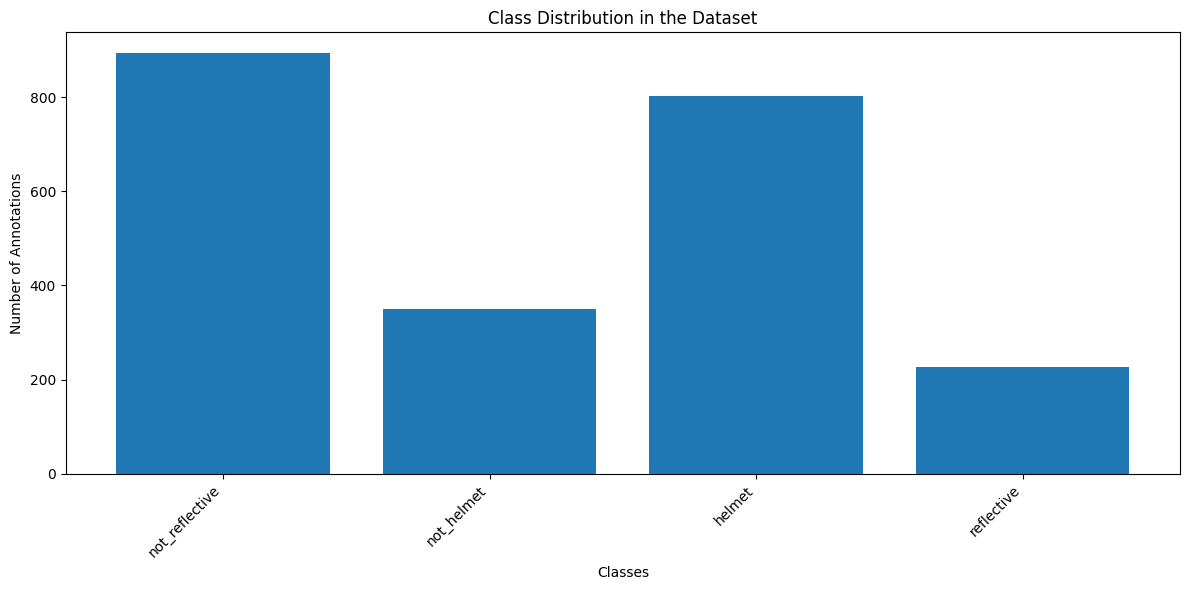

In [10]:
#this is the path to our training labels, no need to change it ;)

annotation_directories =  ['/content/Dataset/train/labels']

#here you should use your own classes as i explained before.

class_list = ['helmet', 'not_helmet', 'not_reflective', 'reflective']

class_occurrences_before = count_class_occurrences_txt(annotation_directories, class_list)

# Create a bar plot to visualize class occurrences
plt.figure(figsize=(12, 6))
plt.bar(class_occurrences.keys(), class_occurrences.values())
plt.xlabel('Classes')
plt.ylabel('Number of Annotations')
plt.title('Class Distribution in the Dataset')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [11]:
#here we are prainting the classes occurrences in numbers  before augmentation
class_occurrences_before

{'not_reflective': 615, 'not_helmet': 250, 'helmet': 544, 'reflective': 158}

---
**Time to increase the size of our training data with new versions of our current pictures so the model can learn from diverce data and we will do this by using a technique called data augmentation using [ALlbumentation](https://albumentations.ai/docs/) library**
---
**Why Albumentations?**

A single interface to work with images, masks, bounding boxes, and key points.
Albumentations provides a single interface to work with different computer vision tasks such as classification, semantic segmentation, instance segmentation, object detection, pose estimation, etc.



In [12]:
import cv2
import os
import numpy as np
import albumentations as A
from albumentations.pytorch import ToTensorV2

# Define input and output directories

input_image_dir = '/content/Dataset/train/images'
input_label_dir = '/content/Dataset/train/labels'
output_image_dir = '/content/Dataset/train/images'
output_label_dir = '/content/Dataset/train/labels'



# List of available augmentation transforms
augmentations = A.Compose([
    # Add your augmentations here
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomRotate90(p=0.5),
    A.RandomBrightnessContrast(p=0.2),
    A.Blur(p=0.2),
    A.ShiftScaleRotate(p=0.5, shift_limit=0.2, scale_limit=0.2, rotate_limit=30),
    ToTensorV2(),
], bbox_params=A.BboxParams(format='yolo', label_fields=['class_labels']))

# Get a list of image files in the input directory
image_files = [f for f in os.listdir(input_image_dir) if f.endswith('.jpg')]

# Process each image and its bounding boxes along with labels
for image_file in image_files:
    image_path = os.path.join(input_image_dir, image_file)
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert to RGB format
    image_name, ext = os.path.splitext(image_file)

    # Load the bounding box annotations
    annotation_file = os.path.join(input_label_dir, image_name + '.txt')
    annotations = []
    class_labels = []  # Store class labels separately
    with open(annotation_file, 'r') as file:
        for line in file:
            parts = list(map(float, line.strip().split()))
            class_id = int(parts[0])
            class_labels.append(class_id)
            bbox = parts[1:]
            annotations.append(bbox)

    augmented = augmentations(image=image, bboxes=annotations, class_labels=class_labels)
    augmented_image = augmented['image']

    # Generate a new file name for the augmented image and labels
    new_image_file = f"{image_name}_augmented{ext}"
    new_annotation_file = f"{image_name}_augmented.txt"

    # Convert the augmented image to a NumPy array
    augmented_image_np = augmented_image.permute(1, 2, 0).cpu().numpy()

    # Save the augmented image and its bounding box annotations with new names
    output_image_path = os.path.join(output_image_dir, new_image_file)
    cv2.imwrite(output_image_path, augmented_image_np)

    output_annotation_file = os.path.join(output_label_dir, new_annotation_file)
    with open(output_annotation_file, 'w') as file:
        for class_id, bbox in zip(class_labels, augmented['bboxes']):
            file.write(f"{class_id} {' '.join(map(str, bbox))}\n")

print(f"A total of {len(image_files)} images and their bounding box annotations were augmented and saved with new file names.")


/usr/local/lib/python3.12/dist-packages/albumentations/core/validation.py:114: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)


A total of 314 images and their bounding box annotations were augmented and saved with new file names.


---
📈 **And here we will check our Data Augmentation results** 🔥
---



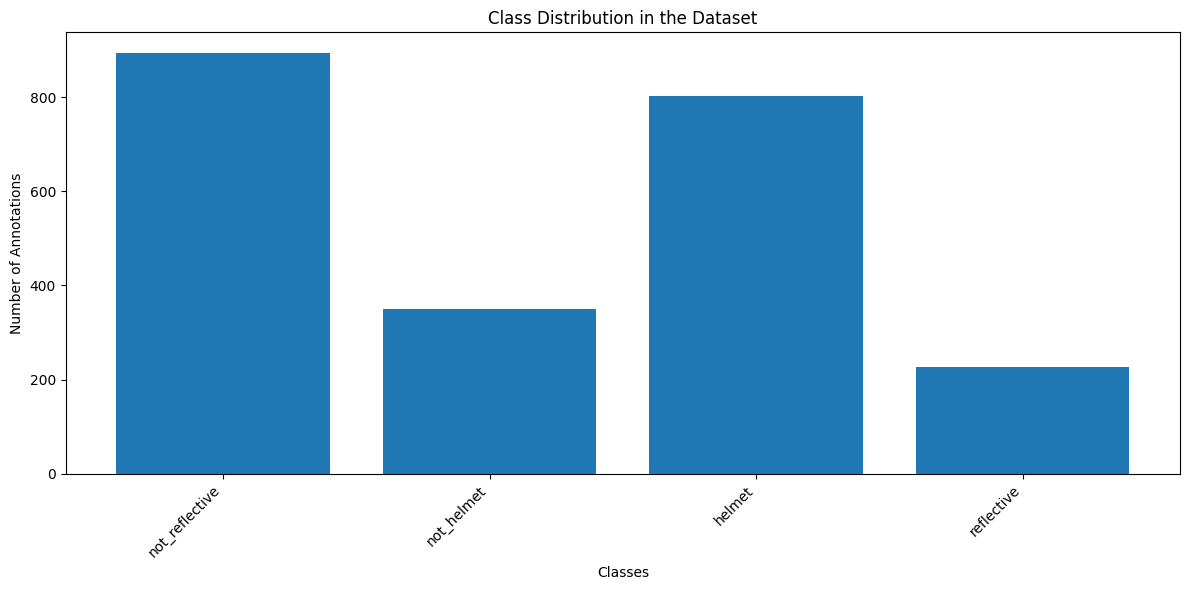

In [13]:
#here we should define our train set path where we applyied augmentation
annotation_directories =  ['/content/Dataset/train/labels']

# here you should use your own classes list as i explained before
class_list = ['helmet', 'not_helmet', 'not_reflective', 'reflective']


class_occurrences_aug = count_class_occurrences_txt(annotation_directories, class_list)

# Create a bar plot to visualize class occurrences
plt.figure(figsize=(12, 6))
plt.bar(class_occurrences.keys(), class_occurrences.values())
plt.xlabel('Classes')
plt.ylabel('Number of Annotations')
plt.title('Class Distribution in the Dataset')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

---
**This how the result of our first task should be 🥇**
---
As a result we should get:
 * a clear increasment in our classes occurences
 * banch of new images in our training set presenting diverce transformation.





In [14]:
#classes ocurrences in numbers before augmentation
class_occurrences_before

{'not_reflective': 615, 'not_helmet': 250, 'helmet': 544, 'reflective': 158}

In [15]:
#here we are prainting the classes occurrences in numbers after augmentation.
class_occurrences_aug

{'not_reflective': 1223, 'not_helmet': 498, 'helmet': 1085, 'reflective': 316}

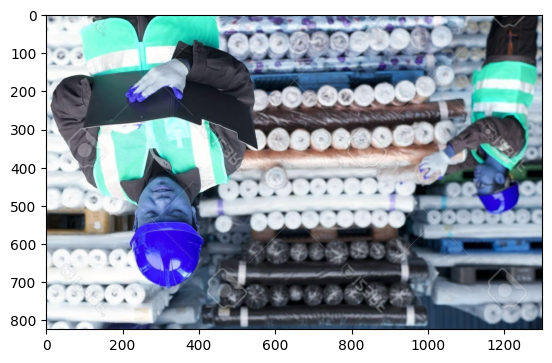

In [17]:
# here you should replace this path with one of the augmented images path in the training set .
# you will find it in this directoty : Dataset=>train=>images/

img = plt.imread('/content/Dataset/train/images/00252_jpg.rf.3b90c4fadfee0974615000c15011d79e_augmented.jpg')
plt.imshow(img)


---
**Here we introduce the second part of our task 🔥**
---



##Training time ⚡

**This YAML file defines the parameters used in training the YOLO model and the paths to the dataset.** ⚾

In [19]:
# Create configuration for Object Detection Pipeline

# Define the data paths for training, validation, and testing datasets.
config = {
   "train": "/content/Dataset/train/images",  # Training dataset path
   "val": "/content/Dataset/valid/images",      # Validation dataset path
   "test": "/content/Dataset/test/images",    # Testing dataset path

   # Number of classes (nc) in your dataset.
   "nc": 4,                                   # Example: 1 for a single class

   # List of class names, where each name corresponds to a unique class ID.
   "names": ['helmet', 'not_helmet', 'not_reflective', 'reflective']   # Example: ['Class1', 'Class2', ...]
}

# Write the configuration to a YAML file.
with open("data.yaml", "w") as file:
   yaml.dump(config, file, default_flow_style=False)


In [20]:
!cat data.yaml

names:
- helmet
- not_helmet
- not_reflective
- reflective
nc: 4
test: /content/Dataset/test/images
train: /content/Dataset/train/images
val: /content/Dataset/valid/images


##The YOLOv8 neural network model was created in five different modifications - n, s, m, l, x, which differ in the number of layers and network parameters. ⚖

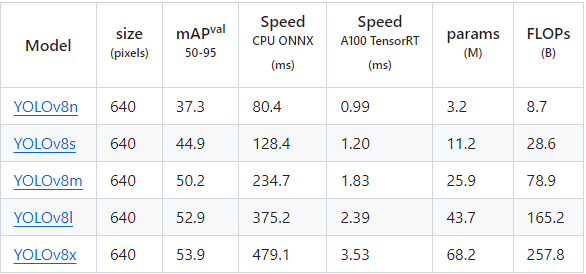

In [21]:
# our training commend
!yolo task=detect mode=train data=data.yaml model=yolov8m.pt epochs=40  project = "/content/drive/MyDrive/checkpoint_numbers/"

Ultralytics 8.3.232 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=40, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8m.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=0.0, plots=True, pose=12.0, pretrained=Tru

##Visualizing our training results


In [30]:


# Read the CSV file
df = pd.read_csv("/content/drive/MyDrive/checkpoint_numbers/train/results.csv")

# Create the line plot
fig = px.line(df, x="epoch", y="metrics/mAP@(B)", title="mAP50")

# Show the figure
fig.show()

ValueError: Value of 'y' is not the name of a column in 'data_frame'. Expected one of ['epoch', 'time', 'train/box_loss', 'train/cls_loss', 'train/dfl_loss', 'metrics/precision(B)', 'metrics/recall(B)', 'metrics/mAP50(B)', 'metrics/mAP50-95(B)', 'val/box_loss', 'val/cls_loss', 'val/dfl_loss', 'lr/pg0', 'lr/pg1', 'lr/pg2'] but received: metrics/mAP@(B)

In [29]:
df = pd.read_csv("")
fig = px.line(df, x='                  epoch', y='       metrics/mAP50(B)', title='mAP50')
fig.show()

ValueError: Value of 'x' is not the name of a column in 'data_frame'. Expected one of ['epoch', 'time', 'train/box_loss', 'train/cls_loss', 'train/dfl_loss', 'metrics/precision(B)', 'metrics/recall(B)', 'metrics/mAP50(B)', 'metrics/mAP50-95(B)', 'val/box_loss', 'val/cls_loss', 'val/dfl_loss', 'lr/pg0', 'lr/pg1', 'lr/pg2'] but received:                   epoch

##Testing our model using image and video test




**A custom fonction to test our model on an image**

No need to change anything ❎


In [ ]:
from ultralytics import YOLO
import cv2
from PIL import Image
from google.colab.patches import cv2_imshow  # Import for displaying images in Colab

def detect_objects_on_image(image_path, output_image_path, model_path, classes):
    """
    Function receives an image file path,
    passes it through YOLOv8 neural network
    and returns an array of detected objects
    and their bounding boxes. It also saves
    the image with bounding boxes drawn.

    :param image_path: Path to the input image file
    :param output_image_path: Path to save the output image with bounding boxes
    :param model_path: Path to the YOLOv8 model
    :param classes: List of class names
    :return: Array of bounding boxes in format
    [[x1, y1, x2, y2, object_type, probability], ...]
    """
    # Load the YOLOv8 model
    model = YOLO(model_path)

    # Open the image using PIL
    image = Image.open(image_path)

    # Pass the image to the YOLO model for prediction
    results = model.predict(image)
    result = results[0]

    # Initialize the output list
    output = []

    # Open the image using OpenCV for drawing bounding boxes
    image_cv = cv2.imread(image_path)

    for box in result.boxes:
        x1, y1, x2, y2 = [round(x) for x in box.xyxy[0].tolist()]
        class_id = int(box.cls[0].item())  # Convert to integer
        prob = round(box.conf[0].item(), 2)
        object_type = classes[class_id]

        # Append the object info to the output list
        output.append([x1, y1, x2, y2, object_type, prob])

        # Draw bounding box on the image
        color = (0, 255, 0)  # Green color for the bounding box (BGR format)
        thickness = 2  # Thickness of the bounding box
        image_cv = cv2.rectangle(image_cv, (x1, y1), (x2, y2), color, thickness)

        # Add text label to the bounding box
        label = f"{object_type}: {prob}"
        cv2.putText(image_cv, label, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 1)

    # Save the image with bounding boxes
    cv2.imwrite(output_image_path, image_cv)

    # Display the output image with bounding boxes
    cv2_imshow(image_cv)  # Use cv2_imshow for Colab

    return output

In [ ]:
image_path = "/content/Dataset/test/images/00266_jpg.rf.3ca2c6bd2c7b3e6565a5a4b95e87f650.jpg"  # Replace with the path to your image
output_image_path = "/content/image_with_boxes.jpg"  # Replace with the desired output image path
model_path = "/content/drive/MyDrive/checkpoint_numbers/train4/weights/best.pt"  # Replace with your model path
classes =  ['helmet', 'not_helmet', 'not_reflective', 'reflective']



detect_objects_on_image(image_path, output_image_path, model_path, classes)
